# 畳み込みニューラルネットワーク

CNNは画像認識や音声認識で用いられ、画像認識のコンペティションではほとんどがCNNをベースにしている。

## 全体の構造

CNNもニューラルネットワークと同じで、レイヤを組み合わせて作る事ができる。
CNNの場合新たにConvolutionレイヤ（畳み込み層）、Poolingレイヤ（プーリング層）を使う。

これまでのニューラルネットワークは隣接する層のすべてを結合する全結合（fully-connected)でAffineレイヤを実装した。


CNNでは Convolution ReLU Poolingという流れ（Poolingは省略されることもある）を繰り返す。
出力に近い層ではこれまで通りAffine-Softmaxの組み合わせが用いられる。

data -> Conv ReLU Pooling Conv ReLU Pooling ... Affine ReLU Affine Softmax

## 畳み込み層

### 全結合層の問題点

全結合ではデータの形状が無視される。画像の場合、28x28の画像を７８４個に並べた。
本来は画像は上下左右に隣接したデータに関連性があるはず。
畳み込み層ではデータ形状を維持して扱えるため、画像などの形状を有したデータを正しく理解できる（可能性がある）。

CNNで畳み込み層の入出力データを特徴マップという場合がある。入力を入力特徴マップ、出力を出力特徴マップと呼ぶ。

### 畳み込み演算

入力データに対しフィルターを積和演算して出力データを計算する。
バイアスは1x1のデータで、すべての項目に対し加算される。

### パディング

入力データの周囲に０などの固定のデータを埋めることをパディングといい、これにより出力データのサイズを大きくできる。
パディングによって出力サイズも大きくしておき、層を減るごとに出力サイズが減って1x1になることを防ぐ。

### ストライド

フィルターを適用する間隔をストライドという。

### 3次元データの畳み込み演算

3次元データの場合、フィルターも3次元にして演算を行い、出力としては同様の2次元になる。

### ブロックで考える

フィルターを複数用意すると(1, OH, OW)から(FN, OH, OW)に出力データのチャンネル数を増やすことができる。

バイアスの形状は(FN, 1, 1)で、全てのチャンネルで同じバイアス値が加算される。

### バッチ処理

## プーリング層

プーリングは縦・横方向の空間を小さくする演算で、2x2 Maxプーリングでは2x2のサイズから最大値のみを取り出す。
プーリングのウィンドウサイズとストライドは同じにして重なりがないようにする。

### プーリング層の特徴

- 学習するパラメータがない
- チャンネル数は変化しない
- 微小な位置変化に対してロバスト

## Convolution / Poolingレイヤの実装

ここでもforward/backwardメソッドを持つレイヤとして実装する。あるトリックを使って簡単に実装することができる。

### 4次元配列

CNNで流れるデータは4次元で、10個のデータが1チャンネルで高さ28、幅28の場合(10, 1, 28, 28)になる。

In [1]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [3]:
x[0].shape, x[1].shape

((1, 28, 28), (1, 28, 28))

### im2colによる展開

畳み込みを真面目にやるとforがネストした複雑な実装になり、NumPyは要素アクセスにforを使わないことが望まれて良くない。

ここではim2colという関数を作る。im2colは3次元のデータを2次元のデータに変換する。
im2colはフィルターにとって都合がいいように入力データを転換する。フィルターを適用する場所の領域を横一列に展開する。これをフィルターが適用されるすべての場所で行う。

こうして横1行に展開した入力データに対し、畳込み層のフィルターを縦1列に展開しその内積を計算するだけでよい。最後にその結果を出力データのサイズに整形する。

### Convolutionレイヤの実装




In [5]:
import os, sys
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
col1.shape

(9, 75)

In [6]:
x2 = np.random.rand(10, 3, 7, 7) # 10個のデータ
col2 = im2col(x2, 5, 5, stride=1, pad=0)
col2.shape

(90, 75)

In [8]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(X, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.cot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

    # backwardの実装は省略

### Poolingレイヤの実装

im2colを使って入力データを展開する。Poolingの場合はチャンネル方向には独立であるようにしておけば、行ごとの最大値を求めて整形すれば良い。


In [9]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 展開（１）
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 最大値（２）
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

## CNNの実装

手書き数字認識を行うCNNを実装する。ネットワークはConv ReLU Pool Affine ReLU Affine Softmaxという流れにする。
これをSimpleConvNetという名前で実装する。


In [10]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

Saved Network Parameters!


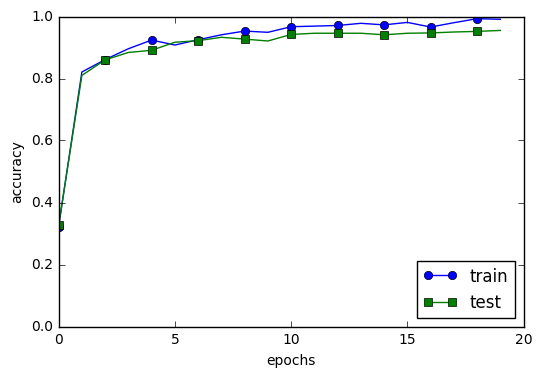

In [2]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000, verbose=False)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## CNNの可視化

先ほどのネットワークでは1層目のフィルタは(30, 1, 5, 5)、サイズが5x5で1チャンネルのフィルタが30個だったので、5x5でグレースケールの画像としてフィルタを可視化できる。

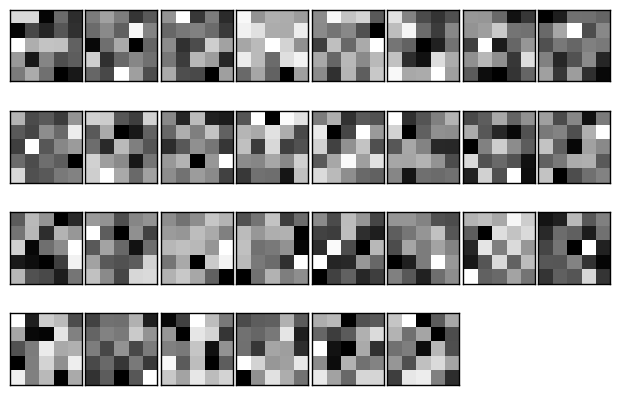

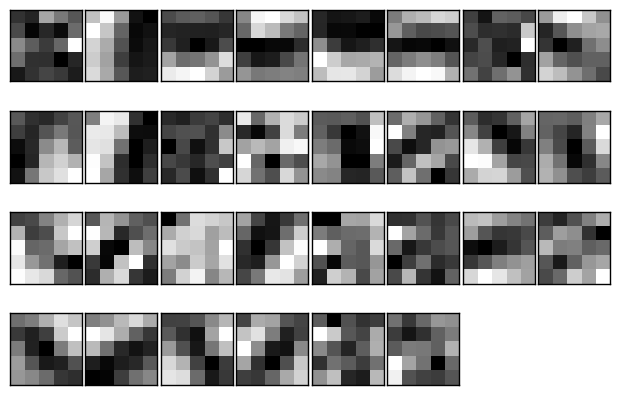

In [1]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

### 階層構造による情報抽出

1層目ではエッジやブロブといった情報になるが、層が深くなるにつれ抽象化される。

単純なエッジからテクスチャ、モノのパーツに反応するように変化する。

## 代表的なCNN

### LeNet

1989年に考案されたLeNetと現在のCNNを比較すると、LeNetでは活性化関数にシグモイド関数を用いているのに対し現在はReLUが主流であること、中間データの縮小をサブサンプリングだったのがMaxプーリングになるなどの差異がある。

### AlexNet
